In [1]:

import torch
from time import time
from DocBuilder.utils import split_list_to_batch, restore_batched_list, unbind_sparse, top_k_sparse, tensor_retuen_type
from DocBuilder.Retriever_k_means import cluster_builder
import matplotlib.pyplot as plt
import numpy as np

/root/miniconda3/envs/RR/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1544


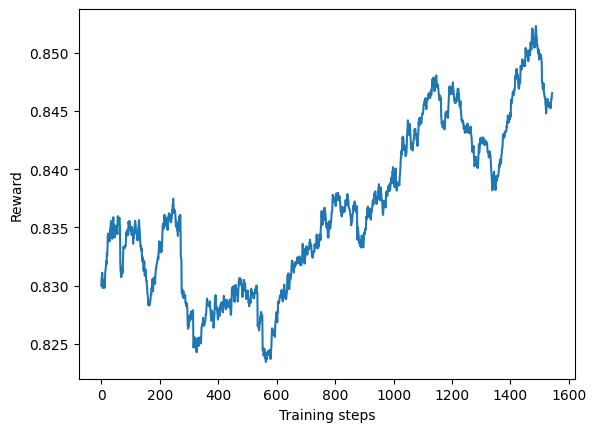

In [35]:

with open("reward_number.txt", "r") as f:
    r = f.readlines()
r = [float(i) for i in r][:]
print(len(r))
moving_avg = []
ma = np.mean(r[:500])
ratio=1-5/len(r)
for x in r:
    ma = ratio * ma + (1-ratio) * x
    moving_avg.append(ma)

plt.ylabel("Reward")
plt.xlabel("Training steps")
plt.plot(moving_avg)
plt.show()

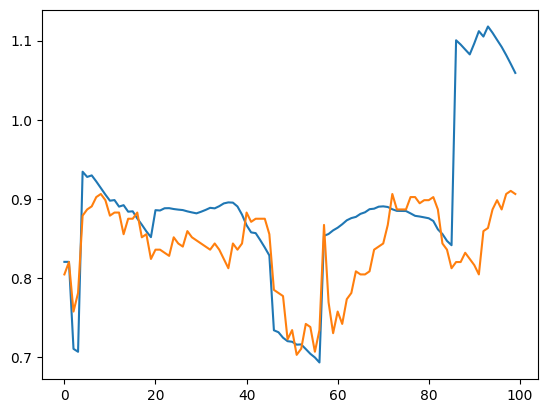

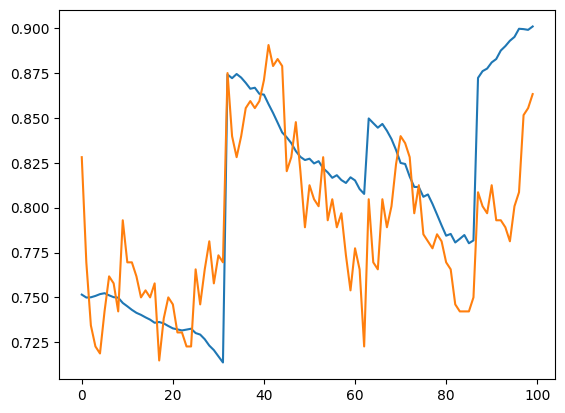

In [32]:
returns = torch.load("save/return.pt")
value = torch.load("save/value.pt")
plt.plot(returns[:100])
plt.plot(value[:100])
plt.show()
plt.plot(returns[100:200])
plt.plot(value[100:200])
plt.show()

In [5]:
from LM.llama_reader import LLaMa_reader
import config
g_config= config.generate_config
g_config.temperature=0.1
model = LLaMa_reader(config.LM_dir, device="cpu",generate_config=g_config)
output = model.generate("hello", max_new_tokens=20)
print(output)

Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00,  5.93it/s]


["! I'm Amber and I'm so glad you're here! ��"]


In [8]:
token, prob = model.pseudo_generate("hello!","I'm Amber and I'm so glad you're here!", temperture=0.5,return_prob=True)

In [15]:

from transformers import BertModel, BertConfig, BertTokenizer, RobertaModel, RobertaTokenizer, RobertaForMaskedLM
import config
bert = RobertaForMaskedLM.from_pretrained(config.roberta_dir, torch_dtype=torch.bfloat16).to(torch.bfloat16)
tokenizer = RobertaTokenizer.from_pretrained(config.roberta_dir)
tokenizer("".join([" retrieve"," proceed"," rewrite"]*3))

{'input_ids': [0, 22661, 9073, 27549, 22661, 9073, 27549, 22661, 9073, 27549, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [12]:
print(token, prob[0])

["I'm aber. I'm a glad you're here!"] tensor([-1.3740e-01, -1.7198e-01, -2.2888e-05, -9.2111e+00, -6.3116e-01,
        -1.7403e+00, -1.1700e-02, -3.0346e-02, -3.4332e-05, -4.0004e-01,
        -1.1650e-02, -7.6294e-06, -1.5945e-03, -1.2207e-04, -3.8147e-06,
        -1.2722e-01])
